# Homework 4

We start by copying all the functions from the last homework. We will use them for comparison with the new ones.

In [1]:
function LU(A)
    n, m = size(A) # A is supposed to be a square matrix, so hopefully n and m will be equal.
    
    # We initalize L with zeros and U to be the same as A.
    L = zeros(n,m)
    U = copy(A)
    
    for k in 1:n
        L[k,k] = 1
        for i in (k+1):n
            L[i,k] = U[i,k]/U[k,k]
            U[i,:] = U[i,:] - L[i,k]*U[k,:]
        end
    end
    return L, U
end

function backward_substitute(U,y)
    n, m = size(U)
    r, = size(y)
    @assert n == m == r
    x = zeros(n)
    
    for i in n:-1:1
        tail = 0
        for j in i+1:n
            tail = tail + U[i,j]*x[j]
        end
        x[i] = (y[i] - tail)/U[i,i]
    end
    
    return x
end

function forward_substitute(L,y)
    n, m = size(L)
    r, = size(y)
    @assert n == m == r
    x = zeros(n)
    for i in 1:n
        tail = 0
        for j in 1:i-1
            tail = tail + L[i,j]*x[j]
        end
        x[i] = (y[i] - tail)/L[i,i]
    end
    return x
end

function solve(A,f)
    n, m = size(A)
    r, = size(f)
    @assert n == m == r
    
    # Something goes here
    L, U = LU(A)
    y = forward_substitute(L,f)
    x = backward_substitute(U,y)
    
    return(x)
end

function big_matrix(n)
    A = zeros(n^2,n^2)
    for i in 1:n^2
        A[i,i] = 4
        if mod(i,n)!=0
            A[i+1,i] = -1
            A[i,i+1] = -1
        end
        if i<=n^2-n
            A[i,i+n] = -1
            A[i+n,i] = -1
        end
    end
    return A
end

function big_rhs(n, f)
    y = zeros(n^2)
    for i in 1:n
        y[i] += f(i/(n+1),0.)
        y[n^2-n+i] += f(i/(n+1),1.)
    end
        
    for i in 1:n
        y[n*i] += f(1.,i/(n+1))
        y[n*i-n+1] += f(0.,i/(n+1))
    end
    return y
end

function T(u::Array{<:Real,2})
    n, m = size(u)
    v = similar(u) # This line creates another array with the same dimensions and type as u
    for i in 1:n
        for j in 1:m
            v[i,j] = 4*u[i,j]
            if i>1 v[i,j] -= u[i-1,j] end
            if i<n v[i,j] -= u[i+1,j] end
            if j>1 v[i,j] -= u[i,j-1] end
            if j<m v[i,j] -= u[i,j+1] end
        end
    end
    return v
end

function matrix_rhs(n::Integer, f::Function)
    b = zeros(n,n)
    for i in 1:n
        b[1,i] += f(0.,i/(n+1))
        b[n,i] += f(1.,i/(n+1))
        b[i,1] += f(i/(n+1),0.)
        b[i,n] += f(i/(n+1),1.)
    end
    return b
end  

function gauss_seidel_iteration!(u::Array{<:Real,2}, b::Array{<:Real,2})
    n, m = size(u)
    for i in 1:n
        for j in 1:m
            s = b[i,j]
            if i>1 s += u[i-1,j] end
            if j>1 s += u[i,j-1] end
            if i<n s += u[i+1,j] end
            if j<m s += u[i,j+1] end
            u[i,j] = s/4
        end
    end
end    

function gauss_seidel(u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    for i in 1:iterations
        gauss_seidel_iteration!(u,b)
    end
    return u
end   

function dot_product(u::Array{<:Real,2}, v::Array{<:Real,2})
    return sum(u.*v)
end

function gradient_descent(u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    for i in 1:iterations
        r = T(u) - b
        a = dot_product(r,r) / dot_product(T(r),r)
        u = u - a*r
    end
    return u
end

gradient_descent (generic function with 1 method)

In [2]:
function conjugate_gradients(u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    old_s = b
    for i in 1:iterations
        r = T(u) - b
        s = r
        if i>1
            s -= ( dot_product(T(s),old_s)/dot_product(T(old_s),old_s) ) * old_s
        end
        a = dot_product(r,s) / dot_product(T(s),s)
        u = u - a*s
        old_s = s
    end
    return u
end

conjugate_gradients (generic function with 1 method)

Let us test how long these algorithms take in practice. So, we will time their execution time with a 40x40 mesh.

In [3]:
n = 40
f(x,y) = 1 - sin(pi*x)
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)

# We use the following function to roughly measure the size of vectors or matrices.
function supnorm(u)
    s = 0
    for entry in u
        s = max(abs(entry),s)
    end
    return s
end

# Using Gaussian elimination
y = big_rhs(n,f)
A = big_matrix(n)
@time x = solve(A,y)
println("Accuracy of Gaussian elimination: ", supnorm(A*x-y) / n^2)

# Using Gauss-Seidel iteration
# We can test different number of iterations

iterations = div(n^2,10)
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gauss_seidel(u,b,iterations)
println("Accuracy of Gauss Seidel with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

iterations = n^2
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gauss_seidel(u,b,iterations)
println("Accuracy of Gauss Seidel with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

iterations = 10*n^2
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gauss_seidel(u,b,iterations)
println("Accuracy of Gauss Seidel with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

# Using Gradient descent
# We can test different number of iterations

iterations = n^2
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gradient_descent(u,b,iterations)
println("Accuracy of Gradient descent with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

# Using Conjugate radients
# We can test different number of iterations

iterations = div(n^2,10)
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = conjugate_gradients(u,b,iterations)
println("Accuracy of conjugate gradients with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

iterations = n^2
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = conjugate_gradients(u,b,iterations)
println("Accuracy of conjugate gradients with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

 33.981548 seconds (5.42 M allocations: 61.665 GiB, 3.90% gc time, 0.70% compilation time)
Accuracy of Gaussian elimination: 1.5959455978986626e-18
  0.044126 seconds (11.17 k allocations: 774.382 KiB, 97.06% compilation time)
Accuracy of Gauss Seidel with 160 iterations: 2.6186415244190688e-6
  0.014016 seconds
Accuracy of Gauss Seidel with 1600 iterations: 5.985804765046288e-10
  0.142270 seconds
Accuracy of Gauss Seidel with 16000 iterations: 4.163336342344337e-19
  0.223682 seconds (234.57 k allocations: 153.004 MiB, 11.14% gc time, 69.22% compilation time)
Accuracy of Gradient descent with 1600 iterations: 9.809590009464409e-8
  0.016255 seconds (5.48 k allocations: 25.805 MiB, 62.20% compilation time)
Accuracy of conjugate gradients with 160 iterations: 4.163336342344337e-19
  0.074344 seconds (20.79 k allocations: 256.371 MiB, 12.52% gc time)
Accuracy of conjugate gradients with 1600 iterations: 4.163336342344337e-19


Conjugate gradients wins by a large margin. In this example, we are getting the exact solution in even fewer iterations than expected. I don't have a good explanation of why, and we shouldn't expect that in general.

We can even solve the problem with a massive mesh of 200x200. It takes less than a minute to get the exact solution in my (old) office computer. Good luck doing that with any of the other methods.

In [4]:
n = 200
f(x,y) = 1 - sin(pi*x)
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)
iterations = n^2
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = conjugate_gradients(u,b,iterations)
println("Accuracy of conjugate gradients with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)

 50.981852 seconds (1.04 M allocations: 154.994 GiB, 5.21% gc time)
Accuracy of conjugate gradients with 40000 iterations: 2.2204460492503132e-20


## Fun movie

Let us make a movie to compare the speed of gradient descent with conjugate gradients.

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/2024/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/2024/tmp.gif")
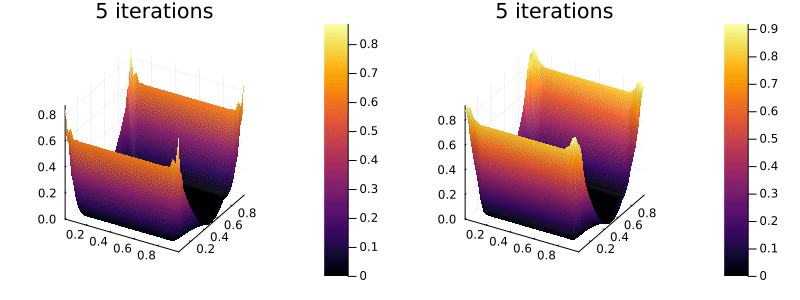

In [5]:
using Plots
iterations = 5
n = 40
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)

let b = matrix_rhs(n,f), u = zeros(n,n), v = zeros(n,n)
    @gif for i in 1:300
        u = gradient_descent(u,b,iterations)
        v = conjugate_gradients(v,b,iterations)
        sgd1 = surface(partition,partition,u, title=string(i*iterations)*" iterations")
        sgd2 = surface(partition,partition,v, title=string(i*iterations)*" iterations")
        sg = plot(sgd1,sgd2,layout=2, size=(800,300))
    end
end

# Interpolation polynomials

Let us explore what we get when we interpolate a function with a polynomial. Let us start with a function that computes Newton's divided differences.

$$ \textbf{newton}(f,[x_1,\dots,x_n]) := f[x_1,\dots,x_n] $$

In order to implement the function below, we use the following formula for $n>1$,
$$ f[x_1, \dots , x_n] = \frac{f[x_1, \dots , x_{n-1}]-f[x_1, \dots , x_{n-2},x_n]}{x_{n-1}-x_n}. $$

With this formula, it is relatively easy to implement **newton** recursively. I include the code below.

In [6]:
function newton(f::Function, x::Vector{<:Real})
    n = length(x)
    if (n==1) return f(x[1]) end
    yn = x[1:end-1]
    yl = vcat(x[1:end-2],[x[n]])
    return (newton(f,yn)-newton(f,yl))/(x[n-1]-x[n])
end

newton (generic function with 1 method)

We load a Julia package called Polynomials. It is used to make computations with polynomials as the name suggests.

In [7]:
import Pkg; Pkg.add("Polynomials")
using Polynomials

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
    Updating `~/Dropbox/tex/classes/Advanced Numerical Analysis/2024/Project.toml`
  [f27b6e38] + Polynomials v4.0.6
  No Changes to `~/Dropbox/tex/classes/Advanced Numerical Analysis/2024/Manifest.toml`
Precompiling project...
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → GeometryBasicsExt
  3 dependencies successfully precompiled in 8 seconds. 310 already precompiled.


The polynomials can be defined from a list of coefficients. Arguably, it looks better to define a global variable `x` that refers to the $x$ polynomial and then do basic arithmetic with it. Let us see.

In [8]:
global x = Polynomial([0,1])
display(1 + 2x + 3x^2 + 5x^3)
display((x-1.5)*(x-2))

Polynomial(1 + 2*x + 3*x^2 + 5*x^3)

Polynomial(3.0 - 3.5*x + 1.0*x^2)

## Exercise 2

Implement a function that returns a polynomial that interpolates f on any given collection of real numbers {x1, x2, ..., xn}.

In [9]:
function interpolate(f::Function, points::Vector{<:Real})
    n = length(points)  # note that the polynomial will be of degree n-1
    p = Polynomial(0)
    terms = []
    for i in 1:n
        term = Polynomial(newton(f,points[1:i]))
        for j in 1:i-1
            term *= (x-points[j])
        end
        p += term
        push!(terms,term)
    end
    return p
end

interpolate (generic function with 1 method)

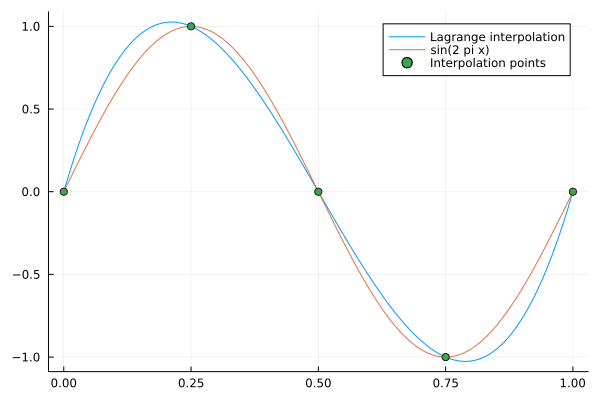

In [10]:
# Let us test if it seems to be working fine
f(t) = sin(2*π*t)
sample = Array(0:0.25:1)
p = interpolate(f,sample)
xg = 0:0.01:1
plot(xg,map(p,xg), label="Lagrange interpolation")
plot!(f,0,1, label="sin(2 pi x)")
scatter!(sample, map(f,sample), label="Interpolation points")

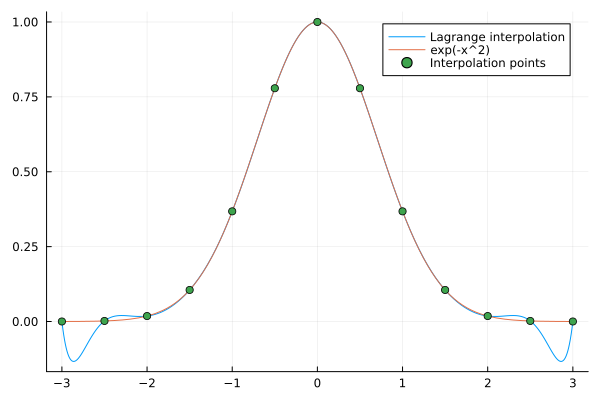

In [11]:
# Let us now try to interpolate the Gaussian function
# The result should be mostly fine, with some artifacts near the end of the interval.

f(t) = exp(-t^2)
sample = Array(-3:0.5:3)
p = interpolate(f,sample)
xg = -3:0.01:3
plot(xg,map(p,xg), label="Lagrange interpolation")
plot!(f,-3,3, label="exp(-x^2)")
scatter!(sample, map(f,sample), label="Interpolation points")

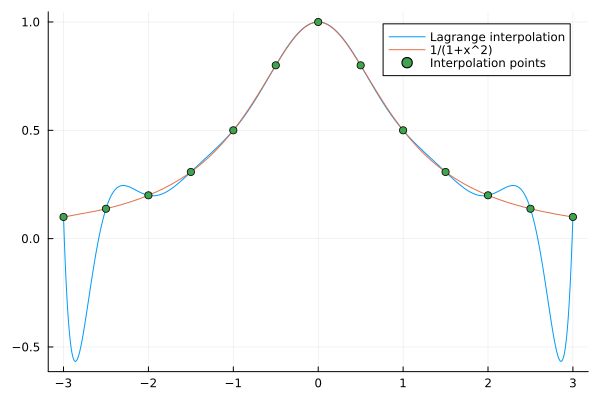

In [12]:
# Let us now try to interpolate the Runge function. It is an example whose higher derivatives grow.
# The result should be pretty bad near the end points of the interval.

f(t) = 1/(1+t^2)
sample = Array(-3:0.5:3)
p = interpolate(f,sample)
xg = -3:0.01:3
plot(xg,map(p,xg), label="Lagrange interpolation")
plot!(f,-3,3, label="1/(1+x^2)")
scatter!(sample, map(f,sample), label="Interpolation points")